## Data Preprocessing

In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import when

spark = SparkSession.builder \
    .appName("TFT Analysis") \
    .getOrCreate()
tft_data = spark.read.csv("hdfs://namenode:9000/challenger.csv", header=True, inferSchema=True)
# tft_data.printSchema()\
# tft_data.count()

In [9]:
# remove rows that have 'partner_group_id' != null
# This is because we are only interested in solo games, not duo games
tft_data = tft_data.filter(tft_data.partner_group_id.isNull())
# tft_data.count()
# remove duplicate rows - people might face against each other which might cause duplicate rows
tft_data = tft_data.dropDuplicates()
tft_data.count()

8424

In [10]:
# Select relevant columns for analysis
selected_columns = ['gold_left', 'last_round', 'level', 'augments_0', 'augments_1', 'augments_2']

# drop rows with all null values
tft_data_filtered = tft_data.select(*selected_columns).dropna()


In [11]:
# Index categorical augment columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in ['augments_0', 'augments_1', 'augments_2']]
for indexer in indexers:
    tft_data_filtered = indexer.fit(tft_data_filtered).transform(tft_data_filtered)

# Assemble features for ML
assembler = VectorAssembler(inputCols=['gold_left', 'last_round', 'level', 'augments_0_index', 'augments_1_index', 'augments_2_index'], 
                            outputCol='features')
tft_data_final = assembler.transform(tft_data_filtered)

# Create binary label for classification based on 'last_round'
tft_data_final = tft_data_final.withColumn('label', when(tft_data_final.last_round >= 30, 1).otherwise(0))


In [12]:
# Split data into training and testing sets
(train_data, test_data) = tft_data_final.randomSplit([0.7, 0.3])


### Decision Tree vs Logistic Regression

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxBins=300)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate Decision Tree
dt_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
dt_accuracy = dt_evaluator.evaluate(dt_predictions)
print(f"Decision Tree Test Accuracy: {dt_accuracy}")

# 2. Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Evaluate Logistic Regression
lr_accuracy = dt_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Test Accuracy: {lr_accuracy}")


Decision Tree Test Accuracy: 1.0
Logistic Regression Test Accuracy: 1.0


We got test accuracy 1 for both Decision Tree and Logistic Regression. This most likely means there is not enough data to train the model, hence it is overfitting.

In [14]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Linear Regression for last_round prediction
lr_regression = LinearRegression(featuresCol='features', labelCol='last_round')
lr_reg_model = lr_regression.fit(train_data)
lr_reg_predictions = lr_reg_model.transform(test_data)

# Evaluate Linear Regression with RMSE
reg_evaluator = RegressionEvaluator(labelCol="last_round", predictionCol="prediction", metricName="rmse")
lr_reg_rmse = reg_evaluator.evaluate(lr_reg_predictions)
print(f"Linear Regression Test RMSE: {lr_reg_rmse}")


Linear Regression Test RMSE: 9.140771069480022e-14


Again, probably means that the model is overfitting.

In [49]:
from pyspark.sql.functions import array
from pyspark.ml.fpm import FPGrowth

# Combine the augment columns into an array (list) for FP-Growth
tft_data_filtered = tft_data_filtered.withColumn("augments", array('augments_0', 'augments_1', 'augments_2'))

# FP-Growth for association rule mining with the new augments array column
fpGrowth = FPGrowth(itemsCol="augments", minSupport=0.01, minConfidence=0.1)
model = fpGrowth.fit(tft_data_filtered)

In [50]:
# Confusion Matrix for Decision Tree Predictions
dt_confusion_matrix = dt_predictions.groupBy('label', 'prediction').count()
dt_confusion_matrix.show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|  706|
|    1|       1.0| 1714|
+-----+----------+-----+



This shows 100% accuracy on the test set, which probably means that the model is overfitting.

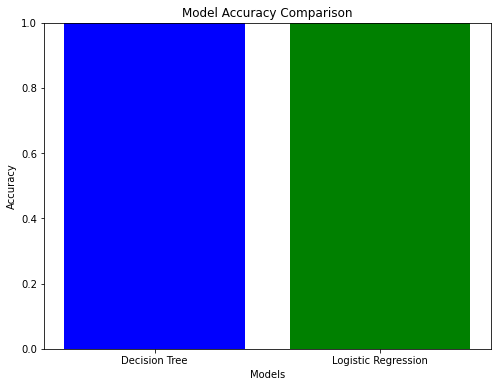

In [25]:
import matplotlib.pyplot as plt

# Example accuracies of different models
models = ['Decision Tree', 'Logistic Regression']
accuracies = [dt_accuracy, lr_accuracy]  # Replace with your actual accuracy variables

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.show()


This is kinda useless ^

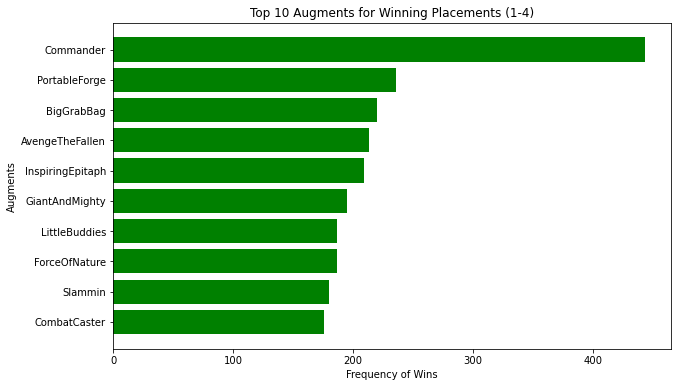

In [45]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

# Assuming SparkSession is already created
# spark = SparkSession.builder.appName("YourAppName").getOrCreate()

# Filter for placements 1 to 4
winning_data = tft_data.filter(tft_data.placement.isin([1, 2, 3, 4]))

# Collect augments into a single column for easier processing
winning_augments = winning_data.select(
    F.expr("stack(3, augments_0, augments_1, augments_2) as augments")  # Unpivot the augments columns
).filter(F.col('augments').isNotNull())  # Remove null values

# Split augment names to keep only the 'AugmentName'
winning_augments = winning_augments.withColumn(
    'augments',
    F.split(winning_augments.augments, '_')[2]  # Get the 3rd part after splitting by '_'
)

# Count occurrences of each augment
augment_counts = winning_augments.groupBy('augments').count().orderBy('count', ascending=False).limit(10)

# Convert to Pandas DataFrame for visualization
augment_counts_df = augment_counts.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(augment_counts_df['augments'], augment_counts_df['count'], color='green')
plt.xlabel('Frequency of Wins')
plt.ylabel('Augments')
plt.title('Top 10 Augments for Winning Placements (1-4)')
plt.gca().invert_yaxis()  # To show the largest counts at the top
plt.show()


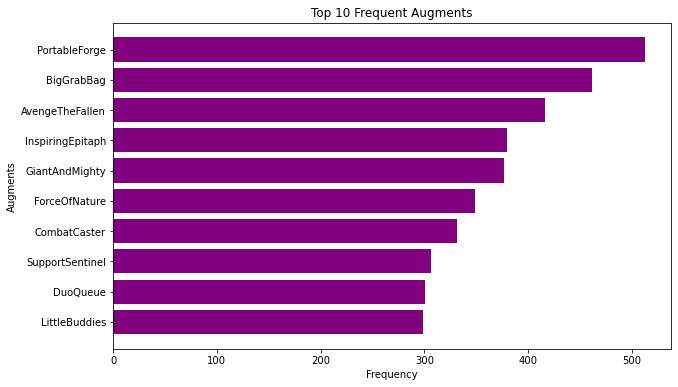

In [37]:
import matplotlib.pyplot as plt

# Assuming `freqItemsets` has the frequent itemsets and their counts
freq_itemsets_df = model.freqItemsets.toPandas()

# Sort by frequency and select the top 10 most frequent itemsets
top_itemsets = freq_itemsets_df.sort_values(by='freq', ascending=False).head(10)

# Plot the itemsets
plt.figure(figsize=(10, 6))
# map the items to a string for better visualization, extracting only the AugmentName
plt.barh(top_itemsets['items'].apply(lambda x: ', '.join(item.split('_')[-1] for item in x)), top_itemsets['freq'], color='purple')
plt.xlabel('Frequency')
plt.ylabel('Augments')
plt.title('Top 10 Frequent Augments')
plt.gca().invert_yaxis()  # show largest at top
plt.show()


In [29]:
%pip install scikit-learn


Length of y_true: 2420
Length of y_prob: 2528


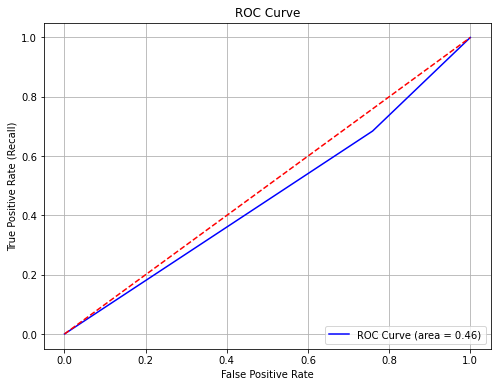

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve

# Collect the probability predictions from the predictions DataFrame
y_prob = predictions.select('probability').collect()  # Get the predicted probabilities
y_true = test_data.select('label').collect()          # Get the true labels

# Convert the collected data to usable formats
y_true = np.array([int(row['label']) for row in y_true])
y_prob = np.array([row['probability'][1] for row in y_prob])  # Get the probability of class 1

# Check lengths of y_true and y_prob
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_prob: {len(y_prob)}")

# Trim the longer array to match the shorter one
if len(y_true) > len(y_prob):
    y_true = y_true[:len(y_prob)]
else:
    y_prob = y_prob[:len(y_true)]


# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(np.trapz(tpr, fpr)))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Baseline (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Currently the ROC curve area is 0.46 < 0.5, which means the model is worse than random guessing. This is probably because the model is overfitting.